In [1]:
import math
import time
import csv
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ['CUDA_VISIBLE_DEVICES']="4"
os.environ['CUDA_LAUNCH_BLOCKING']="1"

import numpy as np
import torch 
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

torch.manual_seed(42)
torch.cuda.manual_seed_all(42)
np.random.seed(42)

import itertools
from tqdm import trange, tqdm
import importlib
import matplotlib.pyplot as plt

from configs import opt, res_trans, RDevelop
from Datas.data_load import dataset_append
from Model.DeePEB_v1 import SpectralConv3d, DeePEB
from utils.Save_and_load import save, load
from Train.train_v1 import train
from Test.Evaluate import evaluate

In [2]:
Resmin, Resmax = [-1000,-1000,0], [80,1000,1000]
masktest = 80
h, k_c, c_sat, D_norm, t_f = 0.027, 0.9, 0.9, 70*70/2/90, 90
datapath, modelpath = opt.datapath, opt.modelpath
ckptname ="DeePEBv1.pth"
ckptpath =  modelpath+ckptname

In [3]:
def Model_def(mode_xy, mode_z, channels, layers, hf_channels, ckptpath=None):
    model = DeePEB([device0, device1], mode_z, mode_xy, mode_xy, channels, layers, hf_channels)
    model.initialize()
    if ckptpath is not None:
        ckpt = torch.load(ckptpath, map_location='cpu')
        model.load_state_dict(ckpt)
    print(model.parameters)
    torch.cuda.empty_cache()
    print(torch.cuda.memory_allocated()/1024/1024/1024, torch.cuda.memory_reserved()/1024/1024/1024)
    return model

In [4]:
mode_xy, mode_z = 50, 40
device0 = device1 = torch.device('cuda:0')
channels = 25
layers = 1
hf_channels = 10
batch_size = 30
model = Model_def(mode_xy, mode_z, channels, layers, hf_channels, ckptpath)

Net Initialized
<bound method Module.parameters of DeePEB(
  (dsp): Sequential(
    (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 2, 2), padding=(1, 1, 1), padding_mode=replicate)
  )
  (fn0): Sequential(
    (0): Linear(in_features=1, out_features=25, bias=True)
  )
  (activation): LeakyReLU(negative_slope=0.01, inplace=True)
  (conv1): SpectralConv3d()
  (w1): Sequential(
    (0): Conv3d(25, 25, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (fn1): Sequential(
    (0): Linear(in_features=25, out_features=64, bias=True)
  )
  (fn2): Sequential(
    (0): Linear(in_features=64, out_features=1, bias=True)
  )
  (usp): Sequential(
    (0): Upsample(scale_factor=(1.0, 2.0, 2.0), mode=trilinear)
  )
  (hf0): Sequential(
    (0): Conv3d(1, 10, kernel_size=(1, 1, 1), stride=(1, 1, 1))
    (1): LeakyReLU(negative_slope=0.01, inplace=True)
    (2): Conv3d(10, 1, kernel_size=(1, 1, 1), stride=(1, 1, 1))
  )
  (hf1): Sequential(
    (0): Conv3d(1, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1),

In [5]:
dataset_train = dataset_append(opt, opt.dataidx_train, res_trans)
dataset_test = dataset_append(opt, opt.dataidx_test, res_trans) 

  0%|          | 0/8 [00:00<?, ?it/s]

../dataset_train_v1/0000Acid_ini Read in 0.15 s
../dataset_train_v1/0000Inhibitor Read in 0.15 s
--> Mask 0 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0001Acid_ini Read in 0.15 s
../dataset_train_v1/0001Inhibitor Read in 0.14 s
--> Mask 1 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0002Acid_ini Read in 0.13 s
../dataset_train_v1/0002Inhibitor Read in 0.13 s
--> Mask 2 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0003Acid_ini Read in 0.12 s
../dataset_train_v1/0003Inhibitor Read in 0.12 s
--> Mask 3 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0004Acid_ini Read in 0.12 s
../dataset_train_v1/0004Inhibitor Read in 0.12 s
--> Mask 4 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 masks left ...

../dataset_train_v1/0005Acid_ini Read in 0.12 s
../dataset_train_v1/0005Inhibito

 12%|█▎        | 1/8 [00:22<02:35, 22.19s/it]

--> Mask 9 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0010Acid_ini Read in 0.11 s
../dataset_train_v1/0010Inhibitor Read in 0.11 s
--> Mask 10 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0011Acid_ini Read in 0.11 s
../dataset_train_v1/0011Inhibitor Read in 0.11 s
--> Mask 11 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0012Acid_ini Read in 0.11 s
../dataset_train_v1/0012Inhibitor Read in 0.11 s
--> Mask 12 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0013Acid_ini Read in 0.11 s
../dataset_train_v1/0013Inhibitor Read in 0.11 s
--> Mask 13 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0014Acid_ini Read in 0.11 s
../dataset_train_v1/0014Inhibitor Read in 0.11 s
--> Mask 14 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 mas

 25%|██▌       | 2/8 [00:44<02:12, 22.11s/it]

--> Mask 19 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0020Acid_ini Read in 0.11 s
../dataset_train_v1/0020Inhibitor Read in 0.11 s
--> Mask 20 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0021Acid_ini Read in 0.11 s
../dataset_train_v1/0021Inhibitor Read in 0.11 s
--> Mask 21 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0022Acid_ini Read in 0.11 s
../dataset_train_v1/0022Inhibitor Read in 0.11 s
--> Mask 22 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0023Acid_ini Read in 0.11 s
../dataset_train_v1/0023Inhibitor Read in 0.11 s
--> Mask 23 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0024Acid_ini Read in 0.11 s
../dataset_train_v1/0024Inhibitor Read in 0.11 s
--> Mask 24 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

 38%|███▊      | 3/8 [01:06<01:50, 22.08s/it]

--> Mask 29 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0030Acid_ini Read in 0.11 s
../dataset_train_v1/0030Inhibitor Read in 0.11 s
--> Mask 30 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0031Acid_ini Read in 0.11 s
../dataset_train_v1/0031Inhibitor Read in 0.11 s
--> Mask 31 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0032Acid_ini Read in 0.11 s
../dataset_train_v1/0032Inhibitor Read in 0.11 s
--> Mask 32 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0033Acid_ini Read in 0.11 s
../dataset_train_v1/0033Inhibitor Read in 0.11 s
--> Mask 33 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0034Acid_ini Read in 0.11 s
../dataset_train_v1/0034Inhibitor Read in 0.11 s
--> Mask 34 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

 50%|█████     | 4/8 [01:28<01:28, 22.07s/it]

--> Mask 39 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0040Acid_ini Read in 0.11 s
../dataset_train_v1/0040Inhibitor Read in 0.11 s
--> Mask 40 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0041Acid_ini Read in 0.11 s
../dataset_train_v1/0041Inhibitor Read in 0.11 s
--> Mask 41 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0042Acid_ini Read in 0.11 s
../dataset_train_v1/0042Inhibitor Read in 0.12 s
--> Mask 42 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0043Acid_ini Read in 0.11 s
../dataset_train_v1/0043Inhibitor Read in 0.11 s
--> Mask 43 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0044Acid_ini Read in 0.11 s
../dataset_train_v1/0044Inhibitor Read in 0.11 s
--> Mask 44 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

 62%|██████▎   | 5/8 [01:50<01:06, 22.05s/it]

--> Mask 49 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0050Acid_ini Read in 0.11 s
../dataset_train_v1/0050Inhibitor Read in 0.11 s
--> Mask 50 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0051Acid_ini Read in 0.11 s
../dataset_train_v1/0051Inhibitor Read in 0.11 s
--> Mask 51 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0052Acid_ini Read in 0.11 s
../dataset_train_v1/0052Inhibitor Read in 0.11 s
--> Mask 52 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0053Acid_ini Read in 0.11 s
../dataset_train_v1/0053Inhibitor Read in 0.11 s
--> Mask 53 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0054Acid_ini Read in 0.11 s
../dataset_train_v1/0054Inhibitor Read in 0.11 s
--> Mask 54 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

 75%|███████▌  | 6/8 [02:12<00:43, 21.99s/it]

--> Mask 59 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0060Acid_ini Read in 0.11 s
../dataset_train_v1/0060Inhibitor Read in 0.11 s
--> Mask 60 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0061Acid_ini Read in 0.11 s
../dataset_train_v1/0061Inhibitor Read in 0.11 s
--> Mask 61 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0062Acid_ini Read in 0.11 s
../dataset_train_v1/0062Inhibitor Read in 0.11 s
--> Mask 62 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0063Acid_ini Read in 0.11 s
../dataset_train_v1/0063Inhibitor Read in 0.12 s
--> Mask 63 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0064Acid_ini Read in 0.11 s
../dataset_train_v1/0064Inhibitor Read in 0.11 s
--> Mask 64 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

 88%|████████▊ | 7/8 [02:34<00:21, 21.97s/it]

--> Mask 69 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0070Acid_ini Read in 0.11 s
../dataset_train_v1/0070Inhibitor Read in 0.11 s
--> Mask 70 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0071Acid_ini Read in 0.11 s
../dataset_train_v1/0071Inhibitor Read in 0.11 s
--> Mask 71 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0072Acid_ini Read in 0.11 s
../dataset_train_v1/0072Inhibitor Read in 0.11 s
--> Mask 72 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0073Acid_ini Read in 0.11 s
../dataset_train_v1/0073Inhibitor Read in 0.11 s
--> Mask 73 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0074Acid_ini Read in 0.11 s
../dataset_train_v1/0074Inhibitor Read in 0.11 s
--> Mask 74 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

100%|██████████| 8/8 [02:55<00:00, 22.00s/it]


--> Mask 79 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...



  0%|          | 0/2 [00:00<?, ?it/s]

../dataset_train_v1/0080Acid_ini Read in 0.14 s
../dataset_train_v1/0080Inhibitor Read in 0.13 s
--> Mask 80 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0081Acid_ini Read in 0.15 s
../dataset_train_v1/0081Inhibitor Read in 0.15 s
--> Mask 81 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0082Acid_ini Read in 0.15 s
../dataset_train_v1/0082Inhibitor Read in 0.15 s
--> Mask 82 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0083Acid_ini Read in 0.15 s
../dataset_train_v1/0083Inhibitor Read in 0.14 s
--> Mask 83 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0084Acid_ini Read in 0.15 s
../dataset_train_v1/0084Inhibitor Read in 0.15 s
--> Mask 84 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 masks left ...

../dataset_train_v1/0085Acid_ini Read in 0.15 s
../dataset_train_v1/0085Inh

 50%|█████     | 1/2 [00:22<00:22, 22.65s/it]

--> Mask 89 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...

../dataset_train_v1/0090Acid_ini Read in 0.14 s
../dataset_train_v1/0090Inhibitor Read in 0.13 s
--> Mask 90 Read Complete, with dataset size: (1, 1, 80, 1000, 1000), 9 masks left ...

../dataset_train_v1/0091Acid_ini Read in 0.15 s
../dataset_train_v1/0091Inhibitor Read in 0.13 s
--> Mask 91 Read Complete, with dataset size: (2, 1, 80, 1000, 1000), 8 masks left ...

../dataset_train_v1/0092Acid_ini Read in 0.15 s
../dataset_train_v1/0092Inhibitor Read in 0.13 s
--> Mask 92 Read Complete, with dataset size: (3, 1, 80, 1000, 1000), 7 masks left ...

../dataset_train_v1/0093Acid_ini Read in 0.15 s
../dataset_train_v1/0093Inhibitor Read in 0.13 s
--> Mask 93 Read Complete, with dataset size: (4, 1, 80, 1000, 1000), 6 masks left ...

../dataset_train_v1/0094Acid_ini Read in 0.14 s
../dataset_train_v1/0094Inhibitor Read in 0.13 s
--> Mask 94 Read Complete, with dataset size: (5, 1, 80, 1000, 1000), 5 ma

100%|██████████| 2/2 [00:45<00:00, 22.53s/it]

--> Mask 99 Read Complete, with dataset size: (10, 1, 80, 1000, 1000), 0 masks left ...



In [6]:
def opt_strategy(model, times=0):
    LR = 1e-3 #*0.5**(times//5)
    optimizer = torch.optim.Adam(model.parameters(), lr=LR,)# weight_decay=1e-4)
    scheduler = None
    #optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.8, )
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-5)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.8)
    return optimizer, scheduler

In [7]:
TotLoss = lambda pred,label: ((pred-label)**2).max()
optimizer, scheduler = opt_strategy(model)
train_log, test_log, lr_log = train(model, optimizer, scheduler, opt, dataset_train, device0,
                                           dataset_test, res_trans, ckptname, TotLoss=TotLoss)
plt.plot(np.mean(train_log.reshape(-1,opt.batch_size),axis=-1));plt.yscale("log");plt.show()

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch 0 | LR: 1.00e-03 | Train Loss: 3.39e-03 | Test Loss: 7.29e-01, 4.31e-03, 9.18%

!Model saved at Epoch 0, with Train Loss 3.39e-03(Total) | Test Error(Ihb): 4.31e-03(MSE), 9.18%(NRMSE)



  0%|          | 1/500 [01:21<11:19:37, 81.72s/it]

!Model saved to  ./Ckpts/DeePEBv1.pth


  4%|▍         | 20/500 [22:35<8:33:53, 64.24s/it] 

Epoch 20 | LR: 1.00e-03 | Train Loss: 2.68e-03 | Test Loss: 4.43e-01, 4.76e-03, 6.03%

!Model saved at Epoch 20, with Train Loss 2.68e-03(Total) | Test Error(Ihb): 4.76e-03(MSE), 6.03%(NRMSE)



  4%|▍         | 21/500 [23:53<9:05:04, 68.28s/it]

!Model saved to  ./Ckpts/DeePEBv1.pth


  8%|▊         | 40/500 [45:32<8:42:30, 68.15s/it]

Epoch 40 | LR: 1.00e-03 | Train Loss: 4.46e-03 | Test Loss: 3.62e-01, 4.14e-03, 5.63%

!Model saved at Epoch 40, with Train Loss 4.46e-03(Total) | Test Error(Ihb): 4.14e-03(MSE), 5.63%(NRMSE)



  8%|▊         | 41/500 [46:58<9:21:20, 73.38s/it]

!Model saved to  ./Ckpts/DeePEBv1.pth


 12%|█▏        | 60/500 [1:08:16<8:08:06, 66.56s/it]

Epoch 60 | LR: 8.00e-04 | Train Loss: 3.85e-03 | Test Loss: 4.71e-01, 3.26e-03, 4.82%

!Model saved at Epoch 60, with Train Loss 3.85e-03(Total) | Test Error(Ihb): 3.26e-03(MSE), 4.82%(NRMSE)



 12%|█▏        | 61/500 [1:09:35<8:35:42, 70.48s/it]

!Model saved to  ./Ckpts/DeePEBv1.pth


 16%|█▌        | 81/500 [1:32:13<8:14:52, 70.87s/it]

Epoch 80 | LR: 8.00e-04 | Train Loss: 2.66e-03 | Test Loss: 1.33e+00, 6.03e-03, 7.81%


 20%|██        | 101/500 [1:54:54<7:45:37, 70.02s/it]

Epoch 100 | LR: 6.40e-04 | Train Loss: 2.53e-03 | Test Loss: 8.35e-01, 3.66e-03, 4.87%


 24%|██▍       | 121/500 [2:18:09<7:25:42, 70.56s/it]

Epoch 120 | LR: 6.40e-04 | Train Loss: 1.02e-03 | Test Loss: 6.68e-01, 5.58e-03, 6.41%


 28%|██▊       | 140/500 [2:38:27<6:36:40, 66.11s/it]

Epoch 140 | LR: 6.40e-04 | Train Loss: 3.02e-03 | Test Loss: 1.80e-01, 1.81e-03, 3.40%

!Model saved at Epoch 140, with Train Loss 3.02e-03(Total) | Test Error(Ihb): 1.81e-03(MSE), 3.40%(NRMSE)



 28%|██▊       | 141/500 [2:39:52<7:10:20, 71.92s/it]

!Model saved to  ./Ckpts/DeePEBv1.pth


 32%|███▏      | 161/500 [3:02:01<6:32:48, 69.52s/it]

Epoch 160 | LR: 5.12e-04 | Train Loss: 1.74e-03 | Test Loss: 2.27e-01, 2.51e-03, 4.61%


 36%|███▌      | 181/500 [3:23:57<6:01:53, 68.07s/it]

Epoch 180 | LR: 5.12e-04 | Train Loss: 3.30e-03 | Test Loss: 9.54e-01, 4.82e-03, 5.59%


 40%|████      | 201/500 [3:46:25<5:51:45, 70.59s/it]

Epoch 200 | LR: 4.10e-04 | Train Loss: 1.21e-03 | Test Loss: 1.45e+00, 6.72e-03, 8.78%


 44%|████▍     | 221/500 [4:08:48<5:21:09, 69.07s/it]

Epoch 220 | LR: 4.10e-04 | Train Loss: 8.14e-04 | Test Loss: 3.78e-01, 3.02e-03, 5.13%


 48%|████▊     | 241/500 [4:30:23<4:50:17, 67.25s/it]

Epoch 240 | LR: 4.10e-04 | Train Loss: 2.32e-03 | Test Loss: 3.86e-01, 3.05e-03, 5.02%


 52%|█████▏    | 261/500 [4:52:00<4:29:13, 67.59s/it]

Epoch 260 | LR: 3.28e-04 | Train Loss: 1.81e-03 | Test Loss: 1.96e-01, 2.41e-03, 3.99%


 56%|█████▌    | 281/500 [5:13:35<4:05:01, 67.13s/it]

Epoch 280 | LR: 3.28e-04 | Train Loss: 1.41e-03 | Test Loss: 1.60e-01, 1.64e-03, 3.91%


 60%|██████    | 301/500 [5:34:56<3:42:04, 66.96s/it]

Epoch 300 | LR: 2.62e-04 | Train Loss: 7.93e-04 | Test Loss: 2.49e-01, 2.94e-03, 4.02%


 64%|██████▍   | 321/500 [5:56:21<3:19:52, 66.99s/it]

Epoch 320 | LR: 2.62e-04 | Train Loss: 7.01e-04 | Test Loss: 6.01e-01, 4.48e-03, 5.37%


 68%|██████▊   | 341/500 [6:18:04<3:02:49, 68.99s/it]

Epoch 340 | LR: 2.62e-04 | Train Loss: 2.57e-03 | Test Loss: 4.07e-01, 4.00e-03, 5.66%


 72%|███████▏  | 361/500 [6:39:26<2:35:31, 67.13s/it]

Epoch 360 | LR: 2.10e-04 | Train Loss: 1.49e-03 | Test Loss: 1.87e-01, 2.25e-03, 3.89%


 76%|███████▌  | 381/500 [7:01:02<2:11:25, 66.27s/it]

Epoch 380 | LR: 2.10e-04 | Train Loss: 2.20e-03 | Test Loss: 8.40e-01, 3.48e-03, 4.83%


 80%|████████  | 401/500 [7:23:14<1:52:47, 68.36s/it]

Epoch 400 | LR: 1.68e-04 | Train Loss: 2.22e-03 | Test Loss: 1.25e+00, 5.32e-03, 7.34%


 84%|████████▍ | 421/500 [7:45:28<1:31:08, 69.22s/it]

Epoch 420 | LR: 1.68e-04 | Train Loss: 5.97e-04 | Test Loss: 6.22e-01, 4.60e-03, 5.82%


 88%|████████▊ | 441/500 [8:06:51<1:05:39, 66.77s/it]

Epoch 440 | LR: 1.68e-04 | Train Loss: 5.69e-04 | Test Loss: 1.21e+00, 5.00e-03, 6.68%


 92%|█████████▏| 461/500 [8:28:44<45:00, 69.26s/it]  

Epoch 460 | LR: 1.34e-04 | Train Loss: 7.81e-04 | Test Loss: 3.39e-01, 2.55e-03, 4.76%


 96%|█████████▌| 481/500 [8:50:05<21:06, 66.67s/it]

Epoch 480 | LR: 1.34e-04 | Train Loss: 6.69e-04 | Test Loss: 3.93e-01, 4.37e-03, 5.78%


100%|██████████| 500/500 [9:10:15<00:00, 66.03s/it]


In [8]:
Runtime, RMSE, NMSE, _, CD_err_x, CD_err_y, CD_RMSE = evaluate(opt, model, device0, res_trans, RDevelop)
print("Mean runtime:", np.mean(Runtime))
print("RMSE(Ihb, rate):", np.mean(RMSE,axis=-1))
print("NRMSE(Ihb, rate):", np.mean(NMSE,axis=-1))
print("CD Error(x, y):", np.mean(CD_RMSE,axis=-1))

  0%|          | 0/20 [00:00<?, ?it/s]

../dataset_train_v1/0080Acid_ini Read in 0.68 s
../dataset_train_v1/0080Inhibitor Read in 0.67 s
RMSE for label 0: [0.005 0.651]
NMSE for label 0: [5.793 1.637]
NMSE_height for label 0: [6.044 1.616]

!Start to clear memory


<<<
time:	0.440626s
<<<



!Start to clear memory


<<<
time:	0.429884s
<<<


CD_x error at height 0:
 [-0.04 -0.04  0.34 -0.09 -0.03  0.04  0.06 -0.   -0.07  0.01  0.05  0.07  0.    0.02 -0.39 -0.06
 -0.15  0.52 -0.58]
CD_y error at height 0:
 [-0.1  -0.03 -0.11 -0.   -0.08 -0.36 -0.03 -0.    0.04 -0.91  0.26  0.11  0.02 -0.18  0.03 -0.1
  0.06  0.02  0.  ]
CD_x error at height 8:
 [-0.05 -0.02 -0.03  1.   -0.01  0.04  1.02  0.27 -0.14 -0.31 -0.    0.19  0.14 -0.49  0.42  0.05
 -0.08  0.16 -0.63]
CD_y error at height 8:
 [-0.04 -0.02 -0.09  0.1   0.12 -0.19  0.01 -0.01 -1.81 -0.01 -0.03 -0.12 -0.01  0.14 -0.04  0.01
  0.05  0.1  -0.01]
CD_x error at height 16:
 [-0.98 -0.04  0.05  0.11 -0.01 -0.04  3.68  1.07  0.04 -0.06  0.02 -2.25  0.06 -0.07  0.14 -0.05
 -0.13  0.05 -0.11]
CD_y error at height 16:
 [-0.16  0.38  0.11 -0.07  0.09  0.1  -0.19 -0.57  0.05 -0.04  0.01 -0.05  0.03  0.14 -0.03 -0.03
 -0.12 -0.01 -0.09]
CD_x error at height 24:
 [ 0.46 -0.27 -0.87 -0.07  0.08  0.03  1.03 -0.28  0.04 -0.06 -0.64  0.94  0.11 -1.1   0.48 -0.01
  0.13 -0.06 -0.18]
CD_y

  5%|▌         | 1/20 [56:30<17:53:45, 3390.81s/it]

CD_x error at height 72:
 [-3.43 -2.04 -1.23  0.35  0.49  0.97 -1.26 -0.14 -2.99 -0.68  0.39  1.21  0.36 -1.89  1.18 -3.26
 -0.23  1.66]
CD_y error at height 72:
 [-0.54  0.41 -2.01  1.53 -0.12 -0.18 -2.23  1.05 -1.91 -1.86  0.41 -2.64  0.22 -2.68 -1.28 -0.95
  1.16  1.03]
CD_RMSE for label 0: [1.063 0.804]
../dataset_train_v1/0081Acid_ini Read in 0.69 s
../dataset_train_v1/0081Inhibitor Read in 0.68 s
RMSE for label 1: [0.006 0.753]
NMSE for label 1: [6.767 1.894]
NMSE_height for label 1: [6.895 1.866]

!Start to clear memory


<<<
time:	0.437917s
<<<
<<<
time:	0.441237s
<<<



!Start to clear memory
CD_x error at height 0:
 [ 0.03  0.07 -0.02  0.14  0.12 -0.02 -0.62  4.07 -0.05 -0.03 -0.03  0.18 -0.13 -0.09  0.05 -0.04
 -0.    0.14  0.05  2.03]
CD_y error at height 0:
 [-0.13  3.55  0.02 -0.04  0.09  0.07  0.01 -0.18  0.05 -0.18 -0.48 -0.45  0.03 -0.06 -0.04  0.17
  0.01  0.1   0.01  0.03]
CD_x error at height 8:
 [-0.05 -0.81 -0.08  0.1   0.11 -0.12 -0.58  3.82 -0.08 -0.   -0.06  0.21  0.13 -0.02  0.05  0.04
 -0.01  0.24 -0.07  0.72]
CD_y error at height 8:
 [ 6.34 -0.04  0.14 -0.    0.07  0.06  0.37  0.16  0.07 -0.07 -0.19 -0.24 -0.1  -0.03  0.09  0.11
 -0.01  0.15  0.05  0.11]
CD_x error at height 16:
 [ 0.05 -0.15  0.37  0.13  0.12 -0.09 -0.13  4.05  0.22  0.05 -0.44 -0.12 -0.02 -0.11  0.08  0.08
  0.07  0.02  0.    1.97]
CD_y error at height 16:
 [ 6.54 -0.04 -0.   -0.02 -0.22 -0.04  0.15  0.19 -0.6  -0.22  0.01 -0.04 -0.1  -0.03  0.58 -0.04
  0.06  0.02 -0.   -0.  ]
CD_x error at height 24:
 [-0.11  0.01 -0.03 -0.22 -0.11  0.93  0.08  3.21  0.77 -0.03

 10%|█         | 2/20 [1:52:12<16:48:38, 3362.14s/it]

CD_x error at height 72:
 [-1.56 -1.08  2.43  0.25  0.25  2.49 -0.22  1.78  2.94 -0.33 -0.33 -0.05 -0.72 -0.63 -1.75  0.86
 -2.7   2.1  -0.69]
CD_y error at height 72:
 [ 1.15 -0.31 -0.61 -3.14  3.01  4.57 -0.26 -1.9   0.25  3.15  1.98 -0.22  0.25  1.1  -0.38 -1.53
  3.4  -0.7   0.56]
CD_RMSE for label 1: [1.462 1.471]
../dataset_train_v1/0082Acid_ini Read in 0.74 s
../dataset_train_v1/0082Inhibitor Read in 0.74 s
RMSE for label 2: [0.002 0.288]
NMSE for label 2: [3.466 0.723]
NMSE_height for label 2: [3.735 0.714]

!Start to clear memory


<<<
time:	0.427761s
<<<
<<<
time:	0.414597s
<<<



!Start to clear memory
CD_x error at height 0:
 [ 0.25 -0.1  -0.76  0.03  0.04  0.11 -0.02 -0.05]
CD_y error at height 0:
 [ 0.09 -0.28 -0.02 -0.01  0.22 -0.31  0.05 -0.3 ]
CD_x error at height 8:
 [ 0.19  0.32  0.12 -0.04  0.05 -0.02  0.04  0.22]
CD_y error at height 8:
 [ 0.02 -0.07 -0.02  0.03 -0.04 -0.31  0.06  0.15]
CD_x error at height 16:
 [ 0.71  0.02  0.07  0.59 -0.17 -0.28  0.25 -0.08]
CD_y error at height 16:
 [-0.    0.04  0.01  0.04 -0.   -0.23  0.06 -0.13]
CD_x error at height 24:
 [ 0.34 -0.01 -0.2  -0.33 -0.04 -0.46  1.   -0.01]
CD_y error at height 24:
 [ 0.01  0.09 -0.04 -0.08 -0.09 -0.33 -0.02 -0.09]
CD_x error at height 32:
 [ 0.16 -0.2   0.49  2.12  0.42  0.62  2.3   0.76]
CD_y error at height 32:
 [-0.01  0.03 -0.03  0.19  0.06  0.13 -0.22 -0.02]
CD_x error at height 40:
 [-0.01 -1.12  0.03 -0.01  0.11 -0.04  0.11  0.07]
CD_y error at height 40:
 [ 0.03  0.03  0.07  0.02  0.02  0.02 -0.07  0.04]
CD_x error at height 48:
 [ 0.02  2.29 -1.43 -0.   -4.16  0.76 -0.03

 15%|█▌        | 3/20 [2:43:34<15:16:20, 3234.13s/it]

CD_x error at height 72:
 [ 1.07 -3.47 -0.39 -3.94 -0.67 -0.61  1.21 -2.53]
CD_y error at height 72:
 [ 1.16 -0.38 -0.75  1.63 -0.53 -1.69 -3.58 -4.38]
CD_RMSE for label 2: [1.034 0.879]
../dataset_train_v1/0083Acid_ini Read in 0.72 s
../dataset_train_v1/0083Inhibitor Read in 0.73 s
RMSE for label 3: [0.005 0.623]
NMSE for label 3: [6.175 1.564]
NMSE_height for label 3: [6.508 1.554]

!Start to clear memory


<<<
time:	0.448508s
<<<



!Start to clear memory


<<<
time:	0.429594s
<<<


CD_x error at height 0:
 [-0.08  2.48  0.02 -0.02 -1.04  0.1   0.73  0.02 -0.18 -0.01  0.11  0.57  0.12 -0.03 -0.02]
CD_y error at height 0:
 [-0.    0.08 -0.22  0.08  0.07 -0.17 -0.16  0.36  0.13 -0.08  0.04  0.23  0.02  0.01  0.07]
CD_x error at height 8:
 [-0.    3.    0.04 -0.05 -3.06  0.07  2.63  0.97  0.02 -0.14 -0.59 -0.02  0.06  0.02  0.03]
CD_y error at height 8:
 [-0.06 -0.15 -0.05 -0.03 -0.01 -0.61  0.01 -0.06  0.05  0.07 -0.15  0.02 -0.26  0.03  0.04]
CD_x error at height 16:
 [-0.61  2.58 -0.06 -0.12 -0.99 -0.02 -0.01  0.65  0.13 -0.25 -0.93 -0.38 -0.4   0.12 -0.58]
CD_y error at height 16:
 [-0.13 -0.11  0.1   0.01 -0.05  0.74  0.03 -0.26  0.03 -0.13 -0.14  0.12  0.03 -0.01  0.08]
CD_x error at height 24:
 [-1.35  2.15 -0.22  0.37 -0.42  0.06  3.16  1.05 -3.81 -0.39  0.11  0.1  -0.09  0.41 -0.66]
CD_y error at height 24:
 [ 0.01  0.08 -0.07 -0.05 -0.   -0.11  0.02  0.04 -0.09 -0.01 -0.08 -0.03 -0.14 -0.03 -0.22]
CD_x error at height 32:
 [-0.1   0.05 -2.11  1.39  0.2  -0.

 20%|██        | 4/20 [3:37:16<14:21:07, 3229.20s/it]

CD_x error at height 72:
 [-4.54 -2.53 -0.27 -3.32 -0.06 -0.31 -3.33 -0.74 -0.13  0.08 -0.94 -0.57 -2.3   3.9  -2.4 ]
CD_y error at height 72:
 [-4.91  2.42 -0.38 -4.27 -1.7   0.15  0.36 -4.62 -3.21  1.7  -0.19 -4.9   0.27 -3.57 -1.42]
CD_RMSE for label 3: [1.399 1.125]
../dataset_train_v1/0084Acid_ini Read in 0.72 s
../dataset_train_v1/0084Inhibitor Read in 0.72 s
RMSE for label 4: [0.001 0.145]
NMSE for label 4: [3.024 0.363]
NMSE_height for label 4: [3.174 0.355]


<<<
time:	0.413684s
<<<



!Start to clear memory


<<<
time:	0.415286s
<<<



!Start to clear memory
CD_x error at height 0:
 [-0.04  0.02  0.04]
CD_y error at height 0:
 [-0.02 -0.03  0.03]
CD_x error at height 8:
 [-0.   -0.13  0.6 ]
CD_y error at height 8:
 [ 0.09  0.03 -0.01]
CD_x error at height 16:
 [ 0.07  0.62 -0.57]
CD_y error at height 16:
 [-0.04 -0.14 -0.01]
CD_x error at height 24:
 [-0.07  0.06 -0.86]
CD_y error at height 24:
 [ 0.1   0.05 -0.01]
CD_x error at height 32:
 [-0.    0.04  3.36]
CD_y error at height 32:
 [ 0.01 -0.01  0.09]
CD_x error at height 40:
 [-0.09  0.39  0.05]
CD_y error at height 40:
 [ 0.07 -0.12  0.01]
CD_x error at height 48:
 [-0.02 -0.02 -0.64]
CD_y error at height 48:
 [ 0.02 -0.    0.08]
CD_x error at height 56:
 [-1.43  0.15  1.34]
CD_y error at height 56:
 [-0.01 -0.03 -0.06]
CD_x error at height 64:
 [-0.39  0.21  0.39]
CD_y error at height 64:
 [1.64 0.57 0.54]


 25%|██▌       | 5/20 [4:26:41<13:03:28, 3133.90s/it]

CD_x error at height 72:
 [-1.32 -1.19 -0.37]
CD_y error at height 72:
 [-1.25 -0.67 -0.34]
CD_RMSE for label 4: [0.841 0.429]
../dataset_train_v1/0085Acid_ini Read in 0.69 s
../dataset_train_v1/0085Inhibitor Read in 0.65 s
RMSE for label 5: [0.002 0.279]
NMSE for label 5: [3.006 0.7  ]
NMSE_height for label 5: [3.259 0.689]

!Start to clear memory


<<<
time:	0.450549s
<<<



!Start to clear memory


<<<
time:	0.431166s
<<<


CD_x error at height 0:
 [-0.03  0.02 -0.06 -0.03  2.81 -0.19 -0.03  0.2  -0.12 -0.96]
CD_y error at height 0:
 [ 0.02 -0.03  0.09  0.05 -0.    0.02  0.01 -0.02 -0.01  0.02]
CD_x error at height 8:
 [ 0.45  0.15  0.05 -0.08 -0.04  0.05 -0.11 -0.14 -0.03 -0.91]
CD_y error at height 8:
 [ 0.28 -0.07  0.03  0.03 -0.1   0.02  0.01 -0.02  0.02 -0.06]
CD_x error at height 16:
 [ 0.08 -0.03  0.01  0.07  0.02  0.11 -0.13 -0.13  0.43  0.82]
CD_y error at height 16:
 [ 0.02 -0.   -0.01  0.36 -0.06  0.01  0.03  0.12 -0.12  0.01]
CD_x error at height 24:
 [ 0.01 -0.03  0.18  0.03  2.67  0.14  0.02 -0.71 -0.57  0.19]
CD_y error at height 24:
 [ 0.01  0.02 -0.09 -0.   -0.    0.06  0.    0.03  0.03  0.  ]
CD_x error at height 32:
 [ 0.69 -1.49 -2.95 -0.76  0.15 -1.72 -0.07 -0.3  -2.95 -0.48]
CD_y error at height 32:
 [-0.   -0.03  0.18 -0.   -0.27 -0.39  0.07  0.04 -0.04 -0.01]
CD_x error at height 40:
 [ 0.03 -0.17 -0.78  1.21  4.67 -0.13 -4.05  0.34 -0.06  2.04]
CD_y error at height 40:
 [ 0.02  0.

 30%|███       | 6/20 [5:17:12<12:03:08, 3099.15s/it]

CD_x error at height 72:
 [-0.84 -2.53 -2.08 -0.55 -0.83 -2.24 -0.58 -0.57 -2.03 -1.11]
CD_y error at height 72:
 [-1.29 -3.36 -1.83 -1.61 -2.74 -0.74 -1.32 -1.45 -2.02 -3.04]
CD_RMSE for label 5: [1.152 0.709]
../dataset_train_v1/0086Acid_ini Read in 0.72 s
../dataset_train_v1/0086Inhibitor Read in 0.73 s
RMSE for label 6: [0.002 0.19 ]
NMSE for label 6: [5.024 0.476]
NMSE_height for label 6: [5.1  0.46]


<<<
time:	0.399185s
<<<



!Start to clear memory


<<<
time:	0.390682s
<<<



!Start to clear memory
CD_x error at height 0:
 [-0.02 -0.57 -0.21]
CD_y error at height 0:
 [-2.8   0.04  0.2 ]
CD_x error at height 8:
 [-0.11  0.17  0.95]
CD_y error at height 8:
 [-0.17  0.01 -0.01]
CD_x error at height 16:
 [ 0.01 -2.66  1.01]
CD_y error at height 16:
 [0.58 0.02 0.39]
CD_x error at height 24:
 [-0.12  0.04  0.98]
CD_y error at height 24:
 [ 3.28 -0.18  0.25]
CD_x error at height 32:
 [-0.02 -0.04  3.08]
CD_y error at height 32:
 [ 5.29  0.01 -0.04]
CD_x error at height 40:
 [-0.   -0.96  2.97]
CD_y error at height 40:
 [ 1.29  0.05 -0.05]
CD_x error at height 48:
 [-1.41  0.93  1.68]
CD_y error at height 48:
 [ 5.54 -0.05 -0.02]
CD_x error at height 56:
 [-0.54 -0.23  3.54]
CD_y error at height 56:
 [ 4.35 -0.    0.15]
CD_x error at height 64:
 [ 1.44 -0.02  1.91]
CD_y error at height 64:
 [5.65 1.81 0.62]


 35%|███▌      | 7/20 [6:09:11<11:12:50, 3105.46s/it]

CD_x error at height 72:
 [-0.47 -1.25]
CD_y error at height 72:
 [-0.88 -0.06]
CD_RMSE for label 6: [1.386 2.157]
../dataset_train_v1/0087Acid_ini Read in 0.73 s
../dataset_train_v1/0087Inhibitor Read in 0.73 s
RMSE for label 7: [0.001 0.183]
NMSE for label 7: [3.8   0.458]
NMSE_height for label 7: [4.003 0.452]


<<<
time:	0.397383s
<<<



!Start to clear memory


<<<
time:	0.41363s
<<<



!Start to clear memory
CD_x error at height 0:
 [-0.16  0.14  0.25]
CD_y error at height 0:
 [-0.    0.05  0.14]
CD_x error at height 8:
 [-0.08  0.08  0.  ]
CD_y error at height 8:
 [ 0.07  0.02 -0.03]
CD_x error at height 16:
 [-0.03 -0.18 -0.51]
CD_y error at height 16:
 [ 0.11  0.04 -0.05]
CD_x error at height 24:
 [ 0.01 -0.34  0.07]
CD_y error at height 24:
 [-0.05 -0.05  0.04]
CD_x error at height 32:
 [-0.27 -1.66 -0.15]
CD_y error at height 32:
 [-0.03  0.    0.13]
CD_x error at height 40:
 [-0.    0.73 -0.99]
CD_y error at height 40:
 [ 0.06 -0.02 -0.03]
CD_x error at height 48:
 [ 0.4  -0.09  1.05]
CD_y error at height 48:
 [-0.06  0.01  0.25]
CD_x error at height 56:
 [-0.88 -2.05  2.82]
CD_y error at height 56:
 [-0.05 -0.19  2.04]
CD_x error at height 64:
 [ 1.76 -0.75  0.61]
CD_y error at height 64:
 [-1.19 -0.06  2.62]


 40%|████      | 8/20 [7:00:45<10:20:22, 3101.91s/it]

CD_x error at height 72:
 [-0.98 -3.78  2.61]
CD_y error at height 72:
 [-0.37 -2.41  1.8 ]
CD_RMSE for label 7: [1.227 0.853]
../dataset_train_v1/0088Acid_ini Read in 0.71 s
../dataset_train_v1/0088Inhibitor Read in 0.72 s
RMSE for label 8: [0.002 0.219]
NMSE for label 8: [3.047 0.548]
NMSE_height for label 8: [3.218 0.544]


<<<
time:	0.411251s
<<<



!Start to clear memory

!Start to clear memory


<<<
time:	0.420428s
<<<


CD_x error at height 0:
 [ 0.51  0.   -0.03 -0.2   0.04 -2.89]
CD_y error at height 0:
 [ 0.06 -0.02  0.04 -0.   -0.09 -0.01]
CD_x error at height 8:
 [ 0.12 -0.01  0.62 -0.21 -0.1  -0.57]
CD_y error at height 8:
 [ 0.07  0.21  0.01  0.02  0.14 -0.05]
CD_x error at height 16:
 [ 0.16  0.06  0.85 -0.31  0.01  0.01]
CD_y error at height 16:
 [-0.02  0.01 -0.05  0.06 -0.23 -0.  ]
CD_x error at height 24:
 [ 0.06 -0.74  0.14  0.05 -0.01  0.15]
CD_y error at height 24:
 [-0.03 -0.01 -0.03 -0.07 -0.05 -0.09]
CD_x error at height 32:
 [ 0.18  0.47  3.62 -0.44 -0.06  3.06]
CD_y error at height 32:
 [-0.05  0.01 -0.02 -0.05  0.1   0.17]
CD_x error at height 40:
 [-0.44  0.07 -0.66 -0.45  0.85 -0.06]
CD_y error at height 40:
 [-0.02  0.14  0.02 -0.03  0.02  0.03]
CD_x error at height 48:
 [-0.35 -0.04  3.74 -0.44  0.79  0.25]
CD_y error at height 48:
 [ 0.08  0.   -0.01 -0.03  0.03 -0.08]
CD_x error at height 56:
 [-1.67 -0.27  1.21 -0.15 -0.03 -0.09]
CD_y error at height 56:
 [ 0.43 -0.    0.11

 45%|████▌     | 9/20 [7:52:17<9:28:05, 3098.66s/it] 

CD_x error at height 72:
 [-0.19 -0.36 -3.04 -1.13 -1.57  0.76]
CD_y error at height 72:
 [-0.38 -2.56 -0.92  1.52 -1.2  -0.67]
CD_RMSE for label 8: [1.116 0.545]
../dataset_train_v1/0089Acid_ini Read in 0.69 s
../dataset_train_v1/0089Inhibitor Read in 0.69 s
RMSE for label 9: [0.002 0.304]
NMSE for label 9: [3.99  0.761]
NMSE_height for label 9: [4.203 0.751]

!Start to clear memory


<<<
time:	0.430236s
<<<
<<<
time:	0.46953s
<<<



!Start to clear memory
CD_x error at height 0:
 [ 0.83 -0.12 -0.02 -0.6  -0.37 -0.64 -0.1 ]
CD_y error at height 0:
 [-0.15  0.26  0.1  -0.07  0.09 -0.01  0.07]
CD_x error at height 8:
 [ 0.91 -0.02  0.11 -0.05  1.07  0.23 -0.77]
CD_y error at height 8:
 [-0.22  0.44 -0.14 -0.21 -0.05  0.07  0.04]
CD_x error at height 16:
 [ 0.83 -0.11  0.06 -0.2  -0.07 -0.05 -0.69]
CD_y error at height 16:
 [-0.   -0.05  0.04  0.04 -0.02 -0.04 -0.01]
CD_x error at height 24:
 [ 0.11 -0.04 -0.73 -0.19  0.29 -0.88  0.22]
CD_y error at height 24:
 [ 0.02 -0.31  0.05 -0.01 -0.08  0.    0.02]
CD_x error at height 32:
 [ 0.4  -0.   -3.67  0.08  0.    0.36 -2.47]
CD_y error at height 32:
 [-0.01  0.01 -0.06  0.07  0.08  0.24 -0.  ]
CD_x error at height 40:
 [ 0.08 -0.15 -1.55  2.23 -3.31 -0.45 -0.56]
CD_y error at height 40:
 [ 0.08 -0.02 -0.17  0.03  0.02  0.05 -0.09]
CD_x error at height 48:
 [ 3.06  0.84 -0.98  0.58  0.76 -1.73 -0.71]
CD_y error at height 48:
 [-0.04 -0.48  0.12 -0.08  0.02 -0.    0.1 ]


 50%|█████     | 10/20 [8:44:19<8:37:38, 3105.81s/it]

CD_x error at height 72:
 [ 0.42 -1.79 -0.79 -2.43  0.54 -1.52 -1.27]
CD_y error at height 72:
 [-3.39 -0.53 -2.25  1.73 -0.1   0.16 -1.51]
CD_RMSE for label 9: [1.217 0.722]
../dataset_train_v1/0090Acid_ini Read in 0.72 s
../dataset_train_v1/0090Inhibitor Read in 0.72 s
RMSE for label 10: [0.003 0.399]
NMSE for label 10: [5.342 1.   ]
NMSE_height for label 10: [5.71  0.992]


<<<
time:	0.430246s
<<<



!Start to clear memory


<<<
time:	0.42069s
<<<



!Start to clear memory
CD_x error at height 0:
 [ 1.01  0.24  0.7  -0.04  0.29  0.05 -0.07  3.07]
CD_y error at height 0:
 [-0.01 -0.08  0.07  0.05 -0.07  0.02  0.11  0.13]
CD_x error at height 8:
 [ 0.67 -0.5  -0.14  0.33 -0.03  0.08 -0.1  -2.53]
CD_y error at height 8:
 [-0.07 -1.96 -0.06  0.08  0.02  0.03 -0.   -0.01]
CD_x error at height 16:
 [-3.01 -2.96  0.06  0.04 -0.07  0.09 -0.51  2.27]
CD_y error at height 16:
 [ 0.22  0.13  0.3   0.04  0.02 -0.01  0.04  0.14]
CD_x error at height 24:
 [ 0.26 -2.   -0.21 -0.36 -0.03 -0.03 -0.16 -4.53]
CD_y error at height 24:
 [-0.08 -0.07 -0.11 -0.07 -0.08 -0.07 -0.    0.28]
CD_x error at height 32:
 [-0.05  0.04  2.91  0.15 -0.   -0.05  0.78  0.41]
CD_y error at height 32:
 [-0.    0.15  0.06  0.01 -0.24  0.11 -0.2  -0.04]
CD_x error at height 40:
 [-0.57  1.45 -4.22 -2.29 -0.02 -0.27 -0.75  0.05]
CD_y error at height 40:
 [ 0.01 -0.04  0.03 -0.04  0.01  0.12 -0.96  0.04]
CD_x error at height 48:
 [-2.47 -2.92 -2.41  0.13  1.99  0.15 -2.54

 55%|█████▌    | 11/20 [9:35:07<7:43:14, 3088.28s/it]

CD_x error at height 72:
 [-1.91 -3.04 -7.55 -2.45 -1.97 -0.76 -3.18 -2.5 ]
CD_y error at height 72:
 [-2.16 -2.17 -2.12 -2.65 -0.75 -3.96 -7.   -4.06]
CD_RMSE for label 10: [1.938 1.306]
../dataset_train_v1/0091Acid_ini Read in 0.71 s
../dataset_train_v1/0091Inhibitor Read in 0.72 s
RMSE for label 11: [0.003 0.401]
NMSE for label 11: [4.158 1.006]
NMSE_height for label 11: [4.322 0.994]

!Start to clear memory


<<<
time:	0.434264s
<<<



!Start to clear memory


<<<
time:	0.428783s
<<<


CD_x error at height 0:
 [ 0.06 -0.26 -0.04  0.07 -0.13 -0.04 -0.02  0.03 -0.02 -0.03  0.12]
CD_y error at height 0:
 [-0.03 -0.13  0.02  0.11  0.88 -0.06  0.08  0.42 -0.04 -0.02 -0.18]
CD_x error at height 24:
 [-0.54  1.76  0.33  0.05 -0.07 -0.23  2.21 -2.56 -0.    0.04  0.01]
CD_y error at height 24:
 [-0.   -0.   -0.03  0.07 -0.01  0.01  0.22  0.1   0.32 -0.11  0.02]
CD_x error at height 32:
 [ 3.16 -0.16 -0.03  0.01 -0.    0.05 -1.66  0.48  0.02  0.81  1.  ]
CD_y error at height 32:
 [-0.01 -0.09 -0.01  0.01 -0.15  0.05  0.06  0.28 -0.03 -0.09 -0.01]
CD_x error at height 40:
 [ 1.1   0.68  0.91 -0.46  0.12  1.49  0.59  3.54 -2.33 -0.78  0.25]
CD_y error at height 40:
 [ 0.01  0.01  0.03 -0.01  0.2   0.43  0.05 -0.24  0.1  -0.21 -0.02]
CD_x error at height 48:
 [-0.03 -2.7   0.48 -1.49 -0.01 -0.03 -0.38  0.91 -0.06 -1.28 -3.22]
CD_y error at height 48:
 [-0.21  1.   -0.01  0.01  0.15 -0.08 -0.03  0.01 -0.07 -0.01  0.25]
CD_x error at height 56:
 [-0.   -0.95  0.14  1.79 -0.22 -0.58

 60%|██████    | 12/20 [10:25:54<6:50:06, 3075.76s/it]

CD_x error at height 72:
 [ 0.78 -2.39 -0.34 -0.73 -3.34 -1.35 -1.33 -1.66 -2.94 -2.43 -2.17]
CD_y error at height 72:
 [-1.76 -3.66 -3.76 -0.84 -0.59 -2.1  -1.86 -1.5   0.4  -2.69 -5.03]
CD_RMSE for label 11: [1.12  0.927]
../dataset_train_v1/0092Acid_ini Read in 0.73 s
../dataset_train_v1/0092Inhibitor Read in 0.73 s
RMSE for label 12: [0.002 0.246]
NMSE for label 12: [4.288 0.616]
NMSE_height for label 12: [4.492 0.601]

!Start to clear memory


<<<
time:	0.40028s
<<<
<<<
time:	0.405003s
<<<



!Start to clear memory
CD_x error at height 0:
 [ 0.17  0.11  0.05 -0.07 -1.23]
CD_y error at height 0:
 [-0.08  0.38 -0.09 -0.16  0.02]
CD_x error at height 8:
 [-0.03 -0.21  0.07 -0.03 -1.09]
CD_y error at height 8:
 [ 0.01 -0.04 -0.   -0.38  0.01]
CD_x error at height 16:
 [-0.2  -0.29  0.61  0.09 -0.66]
CD_y error at height 16:
 [ 0.02  0.14 -0.02  0.12  0.03]
CD_x error at height 24:
 [-0.6  -0.2   0.57 -0.1   1.12]
CD_y error at height 24:
 [-0.01 -0.08 -0.22 -0.04  0.02]
CD_x error at height 32:
 [-0.09 -0.04 -1.29  1.01  0.3 ]
CD_y error at height 32:
 [-0.09 -0.   -0.   -0.06  0.02]
CD_x error at height 40:
 [ 2.55 -0.07  0.05  0.71  0.73]
CD_y error at height 40:
 [ 0.11  0.05  0.07  0.05 -0.02]
CD_x error at height 48:
 [ 1.27 -0.37 -0.41 -0.51  0.5 ]
CD_y error at height 48:
 [-0.01 -0.06 -0.04  0.04  2.81]
CD_x error at height 56:
 [ 2.68 -0.09 -0.67  0.55 -0.08]
CD_y error at height 56:
 [0.58 0.35 0.11 0.64 0.46]
CD_x error at height 64:
 [ 2.82  0.58 -0.59  1.86  1.07]

 65%|██████▌   | 13/20 [11:15:52<5:56:04, 3052.09s/it]

CD_x error at height 72:
 [ 2.29 -0.36 -2.63 -0.07 -2.17]
CD_y error at height 72:
 [-2.78  0.77 -2.97 -0.49  3.02]
CD_RMSE for label 12: [1.065 0.872]
../dataset_train_v1/0093Acid_ini Read in 0.77 s
../dataset_train_v1/0093Inhibitor Read in 0.72 s
RMSE for label 13: [0.002 0.332]
NMSE for label 13: [3.439 0.833]
NMSE_height for label 13: [3.641 0.824]

!Start to clear memory


<<<
time:	0.401334s
<<<



!Start to clear memory


<<<
time:	0.403136s
<<<


CD_x error at height 0:
 [ 0.24  0.05  0.66 -0.04 -0.13 -0.26  0.2   0.03 -0.02  0.24  0.2 ]
CD_y error at height 0:
 [-0.05 -0.04  0.31 -0.03 -0.16  0.01  0.39  0.4   0.05  0.01  0.04]
CD_x error at height 8:
 [-0.   -0.    0.05 -0.06 -0.62 -0.19  0.62 -0.01  0.25  0.06 -0.26]
CD_y error at height 8:
 [ 0.03 -0.09 -0.1  -0.44 -0.1  -0.1   0.02  0.02 -0.17  0.09 -0.02]
CD_x error at height 16:
 [-0.01 -0.05 -0.59  0.76 -0.32  0.2  -0.33  0.43 -0.01 -0.16  0.83]
CD_y error at height 16:
 [-0.04  0.01  0.    0.02  0.01 -0.11 -0.12  0.02  0.04  0.01  0.08]
CD_x error at height 24:
 [-0.   -0.09 -1.1   3.6  -0.04  0.31 -0.11 -0.02 -0.02 -0.05 -0.52]
CD_y error at height 24:
 [-0.03  0.01 -0.   -0.02  0.04  0.09 -0.1   0.03  0.03 -0.12  0.06]
CD_x error at height 32:
 [ 0.14 -0.19  0.92  0.12 -0.1  -2.09  2.28 -0.09  0.63 -0.56  0.08]
CD_y error at height 32:
 [ 0.02 -0.03  0.15  0.01 -0.14 -0.    0.23  0.01 -0.06  0.18  0.13]
CD_x error at height 40:
 [ 0.3  -0.31  0.09  0.57  0.83  2.83 -

 70%|███████   | 14/20 [12:06:49<5:05:21, 3053.59s/it]

CD_x error at height 72:
 [-2.62 -0.47 -0.47 -1.98  0.66 -1.03 -0.82 -2.05 -0.23 -1.26 -4.69]
CD_y error at height 72:
 [-0.64  0.95 -1.37 -2.65 -0.08 -2.86 -4.29 -1.75 -1.27 -3.1  -1.15]
CD_RMSE for label 13: [1.041 0.75 ]
../dataset_train_v1/0094Acid_ini Read in 0.76 s
../dataset_train_v1/0094Inhibitor Read in 0.71 s
RMSE for label 14: [0.011 0.883]
NMSE for label 14: [13.557  2.219]
NMSE_height for label 14: [12.619  2.091]

!Start to clear memory


<<<
time:	0.435132s
<<<
<<<
time:	0.419204s
<<<



!Start to clear memory
CD_x error at height 0:
 [ 0.56 -0.66 -0.08  0.81 -0.02 -0.09  0.08 -0.09  0.06  0.05  0.09 -0.63 -0.1  -0.03  0.15  0.37]
Contact 12 in 0-CD_y_label is redundant, with info [596.84  916.538   1.22 ]
Contact 13 in 0-CD_y_label is redundant, with info [638.841 920.438   1.23 ]
CD_y error at height 0:
 [ 0.04 -0.02 -0.15 -0.35 -0.18 -0.23 -0.12  0.05  0.08 -0.14 -0.26  0.07 -1.22 -1.23 -5.55  0.04
 -0.26 -0.    0.04]
CD_x error at height 8:
 [  0.16   0.47  -0.26  -0.38   0.01  -0.     0.17  -0.17   0.12   0.1   -0.04  -0.11   0.18  -0.04
  -0.03 -17.36]
CD_y error at height 8:
 [-0.43 -0.02 -0.17 -0.09 -0.17  0.21  0.09  0.15 -0.01 -0.11  0.03 -0.   -0.03 -0.01  0.09 -0.01]
CD_x error at height 16:
 [ -0.09  -0.1   -1.06  -0.31   0.2   -2.1   -0.05   0.13   0.05  -0.12  -0.07   0.05   0.01  -0.04
  -0.49 -21.12]
Contact 12 in 16-CD_y_label is redundant, with info [610.84  920.438   1.34 ]
Contact 13 in 16-CD_y_label is redundant, with info [620.191 920.398   1.39

 75%|███████▌  | 15/20 [12:57:31<4:14:10, 3050.02s/it]

CD_x error at height 72:
 [-1.94 -1.92 -2.48 -1.19 -1.4  -1.36 -5.4  -2.83 -0.83 -1.72 -1.78 -2.13 -2.81 -3.39 -1.26]
CD_y error at height 72:
 [-3.5  -6.05 -4.02 -3.34 -2.9  -2.04 -1.06 -1.84 -2.7  -2.75 -0.66 -2.32 -5.14 -2.66 -2.97]
CD_RMSE for label 14: [5.282 5.167]
../dataset_train_v1/0095Acid_ini Read in 0.70 s
../dataset_train_v1/0095Inhibitor Read in 0.72 s
RMSE for label 15: [0.006 0.68 ]
NMSE for label 15: [7.108 1.707]
NMSE_height for label 15: [7.459 1.701]

!Start to clear memory


<<<
time:	0.456394s
<<<
<<<
time:	0.430475s
<<<



!Start to clear memory
CD_x error at height 0:
 [ 0.2   0.03 -0.04  0.02  0.04  0.25  0.05 -0.05  0.05  0.08 -0.03  0.13 -0.05]
CD_y error at height 0:
 [-0.03 -0.01 -0.25 -0.06  0.36 -0.22 -0.02  0.07 -0.03 -0.06  0.03 -0.01 -0.23]
CD_x error at height 8:
 [-0.01  0.19 -0.02 -0.04  0.03  0.04 -0.24  0.01 -0.05  0.01 -0.03  0.52 -0.05]
CD_y error at height 8:
 [-0.03  0.16  0.09  0.28 -0.01  0.02  0.06  0.1  -0.    0.04 -0.08 -0.01 -0.39]
CD_x error at height 16:
 [-0.1  -0.07  0.04  0.1   0.04 -0.01 -0.08  0.04 -0.01  0.09  0.03  0.06  0.08]
CD_y error at height 16:
 [-0.18 -0.02  0.07  0.19 -0.12  0.18  0.06  0.02 -0.06 -0.03  0.02  0.07 -0.04]
CD_x error at height 24:
 [-0.03 -0.14 -0.18 -0.14 -0.01  0.03  0.09 -0.15 -0.    0.13 -0.11  0.07 -0.06]
CD_y error at height 24:
 [ 0.01 -0.12  0.05  0.09  0.02 -0.   -0.02  0.05 -0.09 -0.01  0.04 -0.03  0.05]
CD_x error at height 32:
 [-0.62  0.01 -0.06 -0.    0.02 -0.    0.01  0.19  0.01 -0.01  0.79 -0.88 -0.  ]
CD_y error at height 32:
 

 80%|████████  | 16/20 [13:49:25<3:24:38, 3069.51s/it]

CD_x error at height 72:
 [-4.23 -1.42 -1.36 -3.3  -4.44 -3.95 -3.87 -4.12 -5.16 -5.62  0.11 -3.38 -2.35]
CD_y error at height 72:
 [-3.99 -0.19 -4.94 -3.36 -4.93 -5.38 -3.06 -7.04 -1.89 -5.59 -4.2  -3.06 -2.25]
CD_RMSE for label 15: [1.546 1.408]
../dataset_train_v1/0096Acid_ini Read in 0.71 s
../dataset_train_v1/0096Inhibitor Read in 0.70 s
RMSE for label 16: [0.006 0.753]
NMSE for label 16: [6.277 1.895]
NMSE_height for label 16: [6.425 1.864]

!Start to clear memory


<<<
time:	0.419575s
<<<



!Start to clear memory


<<<
time:	0.449561s
<<<


CD_x error at height 0:
 [-0.15 -0.49  0.03  0.34  0.13  0.16 -0.58  0.19 -0.04 -0.07  1.02 -0.06 -0.07  0.11 -0.36 -0.57
 -0.09 -0.   -0.13 -0.07 -0.06 -0.05  4.08]
CD_y error at height 0:
 [-0.    0.01  0.1  -0.01 -0.02 -0.52  0.01  0.3   0.02  0.25 -0.06  0.04  0.45  0.03 -0.08 -0.02
 -0.02 -0.13 -0.16 -0.07  0.05 -0.1   0.1 ]
CD_x error at height 8:
 [ 0.15 -0.01 -0.17  0.21  0.14  0.57  3.   -0.17 -0.05 -0.    0.01  0.03  0.28  0.09 -0.89  0.07
  0.15  0.04 -0.13 -0.81 -0.09 -0.01  4.1 ]
CD_y error at height 8:
 [ 0.02  0.02  0.01  0.04 -0.36  0.05  0.02  0.12  0.08 -0.06  0.09  0.05  0.01  0.07 -0.01 -0.09
  0.06  0.04 -0.09 -0.46  0.02 -0.55  0.15]
CD_x error at height 16:
 [ 0.18  0.03 -0.65  0.62 -0.01  0.86 -0.19  0.21 -0.02  0.91 -0.02 -0.2  -0.04  0.34 -0.95 -0.01
 -0.03 -0.1  -0.08  0.1  -0.    0.01  0.15]
CD_y error at height 16:
 [ 0.37  0.05  0.01 -0.01 -0.07 -0.01 -0.01 -0.09  0.14 -0.03 -0.1  -0.39 -0.11  0.41 -0.01 -0.16
  0.03  0.01  0.1  -0.06  0.15  0.06  0.  ]
CD

 85%|████████▌ | 17/20 [14:44:37<2:37:06, 3142.21s/it]

CD_x error at height 72:
 [-2.74  0.6  -0.18 -1.34 -0.65  1.23 -1.68  1.73 -2.09  1.5  -1.04  0.39  0.21 -4.22 -0.39 -1.28
 -0.61 -0.47 -0.43 -0.96 -2.67 -7.65]
CD_y error at height 72:
 [-2.99  0.16  0.88 -2.46 -7.12  0.78 -3.54 -0.86 -0.07 -0.49 -0.62  1.29 -0.84 -2.4   0.68  2.52
 -0.01 -0.31 -0.06 -5.57 -3.03  3.13]
CD_RMSE for label 16: [1.3  1.07]
../dataset_train_v1/0097Acid_ini Read in 0.72 s
../dataset_train_v1/0097Inhibitor Read in 0.71 s
RMSE for label 17: [0.005 0.639]
NMSE for label 17: [5.996 1.606]
NMSE_height for label 17: [6.257 1.589]

!Start to clear memory


<<<
time:	0.435902s
<<<
<<<
time:	0.453066s
<<<



!Start to clear memory
CD_x error at height 0:
 [-0.03  0.01 -0.07 -0.62  0.02  0.08  0.08 -0.06  0.31 -0.04  0.07  0.03  0.02 -0.04 -0.14  0.03
  0.12]
CD_y error at height 0:
 [ 0.07 -0.02  0.02 -0.04 -0.1  -0.04  0.24 -0.02 -0.    0.24 -0.22 -0.02 -0.07 -0.14  0.05 -0.27
 -0.02]
CD_x error at height 8:
 [-0.27  0.02 -0.07 -0.19  0.09 -0.02  0.06 -0.5   0.25 -0.03  0.09  0.05  0.06 -0.05 -0.21 -0.33
  0.05]
CD_y error at height 8:
 [ 0.01 -0.07  0.6   0.05 -0.03 -0.12 -0.04  0.09  0.03  0.22 -0.32 -0.02  0.   -0.    0.07  0.14
  0.08]
CD_x error at height 16:
 [ 1.98 -0.01 -0.01 -0.03  0.03  0.11  1.06 -0.06 -0.    0.14  0.11 -0.02  0.14  0.19 -0.23 -0.13
  0.2 ]
CD_y error at height 16:
 [-0.08 -0.13 -0.41 -0.01 -0.1  -0.23 -0.02  0.93 -0.07  0.21 -0.07 -0.01 -0.07  0.08  0.32 -0.04
  0.09]
CD_x error at height 24:
 [-0.63 -2.68  0.01 -0.15  0.07  0.11  1.11  0.01 -0.    2.31  0.02 -0.05  0.05 -0.28  0.22  0.44
 -3.53]
CD_y error at height 24:
 [-0.01  0.1   0.1  -0.04 -0.01 -0.04 

 90%|█████████ | 18/20 [15:38:24<1:45:35, 3167.83s/it]

CD_x error at height 72:
 [ 2.44 -4.07  0.89 -2.49  1.31 -3.17  1.23 -3.54 -1.38  2.2  -4.35 -2.49 -2.73 -1.55 -0.18 -2.28
 -1.2 ]
CD_y error at height 72:
 [-2.86  2.5  -1.72 -2.61  2.06  2.13 -2.68 -0.52  2.01 -5.5  -1.96 -3.75 -5.74 -2.07  1.74 -2.58
 -1.28]
CD_RMSE for label 17: [1.266 1.12 ]
../dataset_train_v1/0098Acid_ini Read in 0.73 s
../dataset_train_v1/0098Inhibitor Read in 0.73 s
RMSE for label 18: [0.006 0.719]
NMSE for label 18: [6.744 1.808]
NMSE_height for label 18: [6.76  1.784]

!Start to clear memory


<<<
time:	0.435948s
<<<



!Start to clear memory


<<<
time:	0.462419s
<<<


Contact 18 in 0-CD_x_label is redundant, with info [348.864 879.947   5.78 ]
CD_x error at height 0:
 [-0.2   0.04 -0.   -0.12  0.13 -0.29 -2.66 -0.18  0.09  0.03  0.35  0.02 -0.03  0.06 -0.02  0.03
  0.23  0.1  -5.78 -0.08]
Contact 12 in 0-CD_y_label is redundant, with info [352.084 873.037  11.01 ]
CD_y error at height 0:
 [ -0.17  -0.08   0.02  -0.     0.05   0.17  -0.02  -0.11  -0.03   0.46   0.15  -0.01 -11.01   0.06
  -0.02   0.2    0.04   0.08   0.07   0.36]
Contact 18 in 8-CD_x_label is redundant, with info [349.874 878.247   4.43 ]
Contact 19 in 8-CD_x_label is redundant, with info [350.904 882.597   1.17 ]
CD_x error at height 8:
 [ 0.01 -0.02  0.05  0.19  0.1  -0.37 -0.02  0.05  0.33  0.9   0.38 -0.01  0.9  -0.1   0.01  0.17
  0.1  -0.01 -4.43 -1.17 -0.09]
Contact 12 in 8-CD_y_label is redundant, with info [352.184 874.347   8.16 ]
CD_y error at height 8:
 [-0.04  0.03  0.02 -0.11 -0.02 -0.09  0.13 -0.06  0.05  0.39 -0.03 -0.12 -8.16 -0.    0.    0.25
 -0.06 -0.02 -0.02  0.1

 95%|█████████▌| 19/20 [16:33:11<53:23, 3203.70s/it]  

CD_x error at height 72:
 [ 0.3  -1.9  -3.15 -1.08  0.76 -0.65 -3.17 -4.06 -0.71  0.69 -4.74 -1.23 -2.83  1.47 -0.18 -4.45
 -2.73  0.36 -1.2 ]
CD_y error at height 72:
 [-5.78 -3.37 -4.97 -3.87  1.18 -0.11  1.98 -2.45 -2.28 -0.17 -1.34 -3.81 -2.12 -1.78 -2.11 -2.3
 -0.59  0.32  1.53]
CD_RMSE for label 18: [1.422 1.4  ]
../dataset_train_v1/0099Acid_ini Read in 0.74 s
../dataset_train_v1/0099Inhibitor Read in 0.73 s
RMSE for label 19: [0.002 0.222]
NMSE for label 19: [3.397 0.556]
NMSE_height for label 19: [3.639 0.554]

!Start to clear memory


<<<
time:	0.400349s
<<<
<<<
time:	0.423298s
<<<



!Start to clear memory
CD_x error at height 0:
 [ 0.1  -0.02  0.14 -0.11  0.01]
CD_y error at height 0:
 [0.05 0.41 0.22 0.08 0.1 ]
CD_x error at height 8:
 [ 0.95  1.06 -0.01  0.02  0.05]
CD_y error at height 8:
 [0.33 0.01 0.11 0.02 0.14]
CD_x error at height 16:
 [-0.    0.06  0.09  0.59  0.54]
CD_y error at height 16:
 [-0.    0.06  0.03 -0.4   0.06]
CD_x error at height 24:
 [ 0.3   0.17 -0.31  0.87  0.19]
CD_y error at height 24:
 [-0.03 -0.06 -0.2  -0.03  0.08]
CD_x error at height 32:
 [-0.11 -0.4  -0.63  0.18  0.47]
CD_y error at height 32:
 [-0.01  0.04  0.04 -0.01 -0.02]
CD_x error at height 40:
 [-0.97 -0.6  -0.01 -0.01 -0.67]
CD_y error at height 40:
 [-0.01  0.02  0.19  0.04 -0.02]
CD_x error at height 48:
 [-0.71  0.86 -2.35 -0.88  2.07]
CD_y error at height 48:
 [ 0.01 -0.15 -0.09  0.04 -0.05]
CD_x error at height 56:
 [-0.15 -2.15 -0.01 -0.35  0.42]
CD_y error at height 56:
 [ 1.61 -1.68  0.04 -0.06 -0.02]
CD_x error at height 64:
 [-0.26  0.35 -1.25 -1.16  2.42]
CD_y

100%|██████████| 20/20 [17:26:40<00:00, 3140.03s/it]

CD_x error at height 72:
 [-1.39 -2.14 -0.62 -0.76 -0.46]
CD_y error at height 72:
 [-0.36 -3.3  -0.74 -0.47  0.53]
CD_RMSE for label 19: [0.891 0.628]
CD Error: [1.438 1.217]
RMSE(Mean, Std): [0.004 0.446] [0.003 0.232]
NMSE(Mean, Std): [5.22  1.119] [2.349 0.584]
NMSE_height: [[5.062 5.061 5.051 5.047 5.045 5.032 5.022 5.024 5.025 5.032 5.033 5.032 5.036 5.05  5.067 5.069
  5.069 5.072 5.082 5.083 ... 5.301 5.344 5.352 5.417 5.366 5.485 5.523 5.555 5.66  5.708 5.886
  5.935 6.175 6.377 6.682 6.889 7.102 7.464 7.669 7.983]
 [1.284 1.284 1.281 1.279 1.278 1.274 1.274 1.275 1.275 1.275 1.273 1.271 1.268 1.266 1.266 1.262
  1.258 1.253 1.248 1.243 ... 0.953 0.94  0.932 0.92  0.893 0.87  0.847 0.831 0.813 0.803 0.833
  0.866 0.894 0.935 0.979 0.982 0.855 0.748 0.639 0.622]]
Top Error (mean): [6.816 0.835]


Mean runtime: 0.9514372229576111
RMSE(Ihb, rate): [0.004 0.446]
NRMSE(Ihb, rate): [5.22  1.119]
CD Error(x, y): [1.438 1.217]


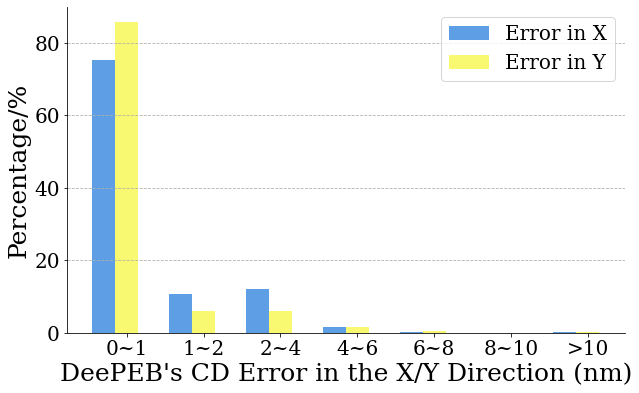

In [9]:
Err_x, Err_y = np.array([]), np.array([])
for tmp in range(len(CD_err_x)):
    Err_x = np.append(Err_x, np.array(CD_err_x[tmp]).flatten())
    Err_y = np.append(Err_y, np.array(CD_err_y[tmp]).flatten())

np.savetxt(opt.respath+"CDErr-x_deepeb.csv", Err_x.flatten(), delimiter=' ')
np.savetxt(opt.respath+"CDErr-y_deepeb.csv", Err_y.flatten(), delimiter=' ')
from utils.Res_plot import CD_errXY_plot
%matplotlib inline
CD_errXY_plot(Err_x, Err_y, "DeePEB's ")